# SimCLR: Comparação de Arquiteturas (Sensor Head vs MLP)

Este notebook compara duas arquiteturas de encoder usando o framework SimCLR:

1. **Sensor Inception Head (CNN)**: Arquitetura que processa cada sensor individualmente com múltiplos tamanhos de kernel
2. **Simple MLP**: Rede neural densa clássica (baseline)

## Configuração do Experimento
- **Divisão de Dados Fixa**: 
  - Teste: 9 bezerros
  - Validação: 5 bezerros
  - Treino: 16 bezerros
- **Pipeline**: Pré-treino SimCLR → Fine-tuning → Avaliação


In [1]:
# Imports
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
import gc

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ Imports completos!")


🖥️ Device: cuda
✅ Imports completos!


In [2]:
# Augmentações para IMU
class IMUAugmentations:
    @staticmethod
    def jitter(x, sigma=0.03):
        return x + np.random.normal(0, sigma, x.shape)

    @staticmethod
    def scaling(x, sigma=0.1):
        factor = np.random.normal(1.0, sigma, size=(1, x.shape[1]))
        return x * factor

    @staticmethod
    def rotation(x):
        if x.shape[1] != 3:
            return x
        angles = np.random.uniform(-np.pi/6, np.pi/6, 3)
        Rx = np.array([[1, 0, 0], [0, np.cos(angles[0]), -np.sin(angles[0])], [0, np.sin(angles[0]), np.cos(angles[0])]])
        Ry = np.array([[np.cos(angles[1]), 0, np.sin(angles[1])], [0, 1, 0], [-np.sin(angles[1]), 0, np.cos(angles[1])]])
        Rz = np.array([[np.cos(angles[2]), -np.sin(angles[2]), 0], [np.sin(angles[2]), np.cos(angles[2]), 0], [0, 0, 1]])
        return x @ (Rz @ Ry @ Rx).T

    @staticmethod
    def time_warp(x, sigma=0.2):
        orig_steps = np.arange(x.shape[0])
        random_warps = np.random.normal(loc=1.0, scale=sigma, size=(3,))
        warp_steps = np.ones((x.shape[0],)) * random_warps[0] + np.linspace(0, random_warps[1], x.shape[0])
        warped_steps = np.cumsum(warp_steps)
        warped_steps = (warped_steps - warped_steps[0]) / (warped_steps[-1] - warped_steps[0]) * (x.shape[0] - 1)
        warped_x = np.zeros_like(x)
        for i in range(x.shape[1]):
            f = interpolate.interp1d(orig_steps, x[:, i], kind='linear', fill_value='extrapolate')
            warped_x[:, i] = f(warped_steps)
        return warped_x

    @staticmethod
    def temporal_masking(x, mask_ratio=0.1):
        x_masked = x.copy()
        seq_len = x.shape[0]
        mask_len = int(seq_len * mask_ratio)
        if mask_len > 0:
            start_idx = np.random.randint(0, seq_len - mask_len)
            x_masked[start_idx:start_idx+mask_len, :] = 0
        return x_masked

    @staticmethod
    def gaussian_blur(x, sigma=0.5):
        blurred = np.zeros_like(x)
        for i in range(x.shape[1]):
            blurred[:, i] = gaussian_filter1d(x[:, i], sigma=sigma)
        return blurred

    @staticmethod
    def apply_random_augmentations(x, n_augs=2):
        x_aug = x.copy()
        augmentations = [
            IMUAugmentations.jitter, IMUAugmentations.scaling, IMUAugmentations.rotation,
            IMUAugmentations.time_warp, IMUAugmentations.temporal_masking, IMUAugmentations.gaussian_blur,
        ]
        selected_augs = np.random.choice(len(augmentations), n_augs, replace=False)
        for aug_idx in selected_augs:
            x_aug = augmentations[aug_idx](x_aug)
        return x_aug

print("✅ Augmentações definidas!")


✅ Augmentações definidas!


In [3]:
# Componentes SimCLR
class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim=128, projection_dim=64):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)
        )
    def forward(self, x):
        return self.projection(x)


class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        z_i = F.normalize(z_i, p=2, dim=1)
        z_j = F.normalize(z_j, p=2, dim=1)
        z = torch.cat([z_i, z_j], dim=0)
        sim_matrix = torch.mm(z, z.T) / self.temperature
        labels = torch.cat([torch.arange(batch_size) + batch_size, torch.arange(batch_size)]).to(z_i.device)
        mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z_i.device)
        sim_matrix = sim_matrix.masked_fill(mask, -9e15)
        return F.cross_entropy(sim_matrix, labels)


class SimCLR(nn.Module):
    def __init__(self, encoder, projection_head):
        super().__init__()
        self.encoder = encoder
        self.projection_head = projection_head

    def forward(self, x_i, x_j):
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)
        z_i = self.projection_head(h_i)
        z_j = self.projection_head(h_j)
        return z_i, z_j


class IMUContrastiveDataset(Dataset):
    def __init__(self, windows, n_augs=2):
        self.windows = windows
        self.n_augs = n_augs

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        view1 = IMUAugmentations.apply_random_augmentations(window, self.n_augs)
        view2 = IMUAugmentations.apply_random_augmentations(window, self.n_augs)
        return torch.FloatTensor(view1).T, torch.FloatTensor(view2).T

print("✅ Componentes SimCLR definidos!")


✅ Componentes SimCLR definidos!


In [4]:
# ============================================================
# ARQUITETURA 1: SENSOR INCEPTION HEAD (CNN Multi-Scale)
# ============================================================
# Processa cada sensor separadamente com múltiplos tamanhos de kernel
# Imita extração de features clássica para dados de sensores

class InceptionBlock1D(nn.Module):
    """
    Bloco Inception com convoluções depthwise (cada sensor processado separadamente).
    5 ramos com diferentes tamanhos de kernel para capturar padrões multi-escala.
    """
    def __init__(self, in_channels, out_channels_per_branch):
        super().__init__()
        groups = in_channels  # Depthwise: cada sensor separado

        # Ramo 1: Kernel pequeno (ruído/detalhes finos)
        self.branch1 = nn.Conv1d(in_channels, out_channels_per_branch * groups, kernel_size=3, padding=1, groups=groups)
        # Ramo 2: Kernel médio-pequeno
        self.branch2 = nn.Conv1d(in_channels, out_channels_per_branch * groups, kernel_size=9, padding=4, groups=groups)
        # Ramo 3: Kernel médio
        self.branch3 = nn.Conv1d(in_channels, out_channels_per_branch * groups, kernel_size=17, padding=8, groups=groups)
        # Ramo 4: Kernel grande
        self.branch4 = nn.Conv1d(in_channels, out_channels_per_branch * groups, kernel_size=33, padding=16, groups=groups)
        # Ramo 5: Kernel gigante (quase toda a janela de 75 samples)
        self.branch5 = nn.Conv1d(in_channels, out_channels_per_branch * groups, kernel_size=75, padding=37, groups=groups)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        b5 = self.branch5(x)
        return torch.cat([b1, b2, b3, b4, b5], dim=1)


class SensorInceptionEncoder(nn.Module):
    """
    Encoder que processa sensores independentemente com múltiplas escalas.

    Tamanho do vetor latente intermediário:
    - 3 sensores * 5 ramos * 16 filtros = 240 canais
    - Depois projeta para embedding_dim (128)
    """
    def __init__(self, in_channels=3, embedding_dim=128, seq_len=75):
        super().__init__()

        self.features_per_scale_per_sensor = 16
        self.inception = InceptionBlock1D(in_channels, self.features_per_scale_per_sensor)

        # Total: 3 * 5 * 16 = 240
        total_channels = in_channels * 5 * self.features_per_scale_per_sensor

        self.bn1 = nn.BatchNorm1d(total_channels)
        self.relu = nn.ReLU(inplace=True)

        # Pointwise conv para misturar informações entre sensores
        self.mixer = nn.Conv1d(total_channels, 256, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(256)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, embedding_dim)

    def forward(self, x):
        x = self.inception(x)
        x = self.relu(self.bn1(x))
        x = self.mixer(x)
        x = self.relu(self.bn2(x))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# ============================================================
# ARQUITETURA 2: SIMPLE MLP (Baseline)
# ============================================================
class SimpleMLPEncoder(nn.Module):
    """
    Encoder simples: Flatten -> Dense -> Dense.
    Baseline sem convoluções.
    """
    def __init__(self, in_channels=3, seq_len=75, embedding_dim=128):
        super().__init__()
        input_dim = in_channels * seq_len  # 3 * 75 = 225

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, embedding_dim)
        )

    def forward(self, x):
        return self.net(x)


print("✅ Arquiteturas definidas:")
print("  1. SensorInceptionEncoder (CNN Multi-Scale Depthwise)")
print("     -> Vetor latente intermediário: 240 canais (3 sensores × 5 escalas × 16 filtros)")
print("     -> Embedding final: 128")
print("  2. SimpleMLPEncoder (Rede Neural Clássica 2 camadas)")
print("     -> Embedding final: 128")


✅ Arquiteturas definidas:
  1. SensorInceptionEncoder (CNN Multi-Scale Depthwise)
     -> Vetor latente intermediário: 240 canais (3 sensores × 5 escalas × 16 filtros)
     -> Embedding final: 128
  2. SimpleMLPEncoder (Rede Neural Clássica 2 camadas)
     -> Embedding final: 128


In [5]:
# Classificador para Fine-tuning
class BehaviorClassifier(nn.Module):
    def __init__(self, encoder, embedding_dim=128, num_classes=8):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: (batch, time_steps, channels) -> (batch, channels, time_steps)
        x = x.transpose(1, 2)
        h = self.encoder(x)
        return self.classifier(h)

    def unfreeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = True

print("✅ Classificador definido!")


✅ Classificador definido!


In [6]:
# Funções Auxiliares
def create_windows(df, window_size=75, overlap=0.5, feature_columns=['accX', 'accY', 'accZ']):
    """Cria janelas deslizantes de IMU"""
    stride = int(window_size * (1 - overlap))
    windows, labels, calves = [], [], []

    for calf_id in df['calfId'].unique():
        df_calf = df[df['calfId'] == calf_id].copy()
        for behavior_name in df_calf['behaviour'].unique():
            df_behavior = df_calf[df_calf['behaviour'] == behavior_name].reset_index(drop=True)
            features = df_behavior[feature_columns].values
            for i in range(0, len(features) - window_size + 1, stride):
                window = features[i:i+window_size]
                if window.shape[0] == window_size:
                    windows.append(window)
                    labels.append(behavior_name)
                    calves.append(calf_id)
    return np.array(windows), np.array(labels), np.array(calves)


def pretrain_simclr(model, train_loader, val_loader, criterion, optimizer, scheduler,
                    device, num_epochs=50, patience=10, save_path='simclr_best.pth'):
    """Loop de pré-treino SimCLR"""
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': []}

    # Nome base para checkpoints
    checkpoint_base = save_path.replace('.pth', '')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for view1, view2 in train_loader:
            view1, view2 = view1.to(device), view2.to(device)
            optimizer.zero_grad()
            z_i, z_j = model(view1, view2)
            loss = criterion(z_i, z_j)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for view1, view2 in val_loader:
                view1, view2 = view1.to(device), view2.to(device)
                z_i, z_j = model(view1, view2)
                val_loss += criterion(z_i, z_j).item()
        val_loss /= len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if epoch % 10 == 0:
            print(f"  Epoch [{epoch+1}/{num_epochs}] Train: {train_loss:.4f} | Val: {val_loss:.4f}")

        # Checkpoint a cada 50 épocas
        if (epoch + 1) % 50 == 0:
            checkpoint_path = f"{checkpoint_base}_epoch{epoch+1}.pth"
            torch.save(model.encoder.state_dict(), checkpoint_path)
            print(f"  💾 Checkpoint salvo: {checkpoint_path}")

        if scheduler: scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.encoder.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stopping na época {epoch+1}")
                break

    return history

print("✅ Funções auxiliares definidas!")


✅ Funções auxiliares definidas!


In [7]:
# ============================================================
# PREPARAÇÃO DE DADOS (Nova Divisão Fixa)
# ============================================================
print("Carregando AcTBeCalf.parquet...")
df = pl.read_parquet('AcTBeCalf.parquet').to_pandas()

# --- DIVISÃO FIXA DE DADOS ---
# Teste: 9 bezerros | Validação: 5 bezerros | Treino: 16 bezerros

test_calves = ['1319', '1333', '1351', '1403', '1302', '1303', '1306', '1308', '1312']
val_calves = ['1320', '1405', '1314', '1328', '1329']
train_calves = [
    '1335', '1336', '1343', '1353', '1357', '1372', '1398', '1408',
    '1409', '1416', '1433', '1443', '1444', '1449', '1452', '1455'
]

print(f"\n📊 Divisão de Bezerros:")
print(f"  Teste ({len(test_calves)}): {test_calves}")
print(f"  Val ({len(val_calves)}): {val_calves}")
print(f"  Treino ({len(train_calves)}): {train_calves}")

# Filtrar top 8 classes
class_counts = df['behaviour'].value_counts()
top_8_classes = class_counts.head(8).index.tolist()
df = df[df['behaviour'].isin(top_8_classes)].copy()

# Label encoder
label_encoder = LabelEncoder()
label_encoder.fit(sorted(top_8_classes))
NUM_CLASSES = len(label_encoder.classes_)

print(f"\nClasses ({NUM_CLASSES}): {list(label_encoder.classes_)}")

# Criar janelas
print("\n🔧 Criando janelas...")
WINDOW_SIZE = 75
OVERLAP = 0.75

df_train = df[df['calfId'].isin(train_calves)]
train_windows, train_labels, _ = create_windows(df_train, WINDOW_SIZE, OVERLAP)

df_val = df[df['calfId'].isin(val_calves)]
val_windows, val_labels, _ = create_windows(df_val, WINDOW_SIZE, OVERLAP)

df_test = df[df['calfId'].isin(test_calves)]
test_windows, test_labels, _ = create_windows(df_test, WINDOW_SIZE, OVERLAP)

print(f"\n📊 Janelas criadas:")
print(f"  Treino: {train_windows.shape[0]:,} janelas")
print(f"  Validação: {val_windows.shape[0]:,} janelas")
print(f"  Teste: {test_windows.shape[0]:,} janelas")


Carregando AcTBeCalf.parquet...

📊 Divisão de Bezerros:
  Teste (9): ['1319', '1333', '1351', '1403', '1302', '1303', '1306', '1308', '1312']
  Val (5): ['1320', '1405', '1314', '1328', '1329']
  Treino (16): ['1335', '1336', '1343', '1353', '1357', '1372', '1398', '1408', '1409', '1416', '1433', '1443', '1444', '1449', '1452', '1455']

Classes (8): [np.str_('drinking_milk'), np.str_('eating_bedding'), np.str_('eating_concentrates'), np.str_('grooming'), np.str_('lying'), np.str_('oral_manipulation_of_pen'), np.str_('sniff'), np.str_('standing')]

🔧 Criando janelas...

📊 Janelas criadas:
  Treino: 44,810 janelas
  Validação: 19,514 janelas
  Teste: 46,782 janelas


In [8]:
# Preparação dos DataLoaders
N_AUGMENTATIONS = 2
train_contrastive_dataset = IMUContrastiveDataset(train_windows, n_augs=N_AUGMENTATIONS)
val_contrastive_dataset = IMUContrastiveDataset(val_windows, n_augs=N_AUGMENTATIONS)

train_contrastive_loader = DataLoader(train_contrastive_dataset, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True)
val_contrastive_loader = DataLoader(val_contrastive_dataset, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)

# DataLoaders Supervisionados
train_y_enc = label_encoder.transform(train_labels)
val_y_enc = label_encoder.transform(val_labels)
test_y_enc = label_encoder.transform(test_labels)

train_sup_loader = DataLoader(
    TensorDataset(torch.FloatTensor(train_windows), torch.LongTensor(train_y_enc)),
    batch_size=1024, shuffle=True, num_workers=4, pin_memory=True
)
val_sup_loader = DataLoader(
    TensorDataset(torch.FloatTensor(val_windows), torch.LongTensor(val_y_enc)),
    batch_size=1024, shuffle=False, num_workers=4, pin_memory=True
)
test_sup_loader = DataLoader(
    TensorDataset(torch.FloatTensor(test_windows), torch.LongTensor(test_y_enc)),
    batch_size=1024, shuffle=False, num_workers=4, pin_memory=True
)

print("✅ DataLoaders prontos!")


✅ DataLoaders prontos!


In [9]:
# ============================================================
# FUNÇÃO DE EXPERIMENTAÇÃO COMPLETA
# ============================================================
def run_experiment(encoder_class, experiment_name, epochs_pretrain=100, epochs_finetune=100):
    """
    Executa pipeline completo: Pré-treino SimCLR → Fine-tuning → Avaliação
    """
    print("="*80)
    print(f"🚀 EXPERIMENTO: {experiment_name}")
    print("="*80)

    # 1. Inicializar Modelos
    encoder = encoder_class(in_channels=3, embedding_dim=128)
    proj_head = ProjectionHead(embedding_dim=128, projection_dim=64)
    simclr_model = SimCLR(encoder, proj_head).to(device)

    n_params = sum(p.numel() for p in simclr_model.parameters())
    print(f"Parâmetros totais: {n_params:,}")

    # ===== PRÉ-TREINO =====
    print(f"\n🔥 [1/3] Pré-treino SimCLR ({epochs_pretrain} epochs)...")
    optimizer = torch.optim.Adam(simclr_model.parameters(), lr=3e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs_pretrain)
    criterion = NTXentLoss(temperature=0.5)

    history_pre = pretrain_simclr(
        simclr_model, train_contrastive_loader, val_contrastive_loader,
        criterion, optimizer, scheduler, device,
        num_epochs=epochs_pretrain, patience=15, save_path=f'simclr_{experiment_name}.pth'
    )

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(history_pre['train_loss'], label='Train')
    plt.plot(history_pre['val_loss'], label='Val')
    plt.title(f'SimCLR Loss - {experiment_name}')
    plt.xlabel('Epoch'); plt.ylabel('NT-Xent Loss')
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    # ===== FINE-TUNING =====
    print(f"\n🎯 [2/3] Fine-tuning Supervisionado...")

    best_encoder = encoder_class(in_channels=3, embedding_dim=128)
    best_encoder.load_state_dict(torch.load(f'simclr_{experiment_name}.pth', map_location=device))

    classifier = BehaviorClassifier(best_encoder, num_classes=NUM_CLASSES).to(device)
    criterion_ce = nn.CrossEntropyLoss()

    # Fase 1: Apenas Head
    print("  -> Fase 1: Treinando apenas classificador (encoder congelado)...")
    for param in classifier.encoder.parameters():
        param.requires_grad = False

    optimizer_ft = torch.optim.Adam(
        filter(lambda p: p.requires_grad, classifier.parameters()),
        lr=1e-3, weight_decay=1e-4
    )

    for epoch in range(50):
        classifier.train()
        for bx, by in train_sup_loader:
            bx, by = bx.to(device), by.to(device)
            optimizer_ft.zero_grad()
            loss = criterion_ce(classifier(bx), by)
            loss.backward()
            optimizer_ft.step()

    # Fase 2: Full Fine-tuning
    print("  -> Fase 2: Fine-tuning completo...")
    classifier.unfreeze_encoder()
    optimizer_full = torch.optim.Adam(classifier.parameters(), lr=1e-5, weight_decay=1e-4)

    best_val_acc = 0
    patience, patience_cnt = 20, 0

    for epoch in range(epochs_finetune):
        classifier.train()
        for bx, by in train_sup_loader:
            bx, by = bx.to(device), by.to(device)
            optimizer_full.zero_grad()
            loss = criterion_ce(classifier(bx), by)
            loss.backward()
            optimizer_full.step()

        # Validation
        classifier.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for bx, by in val_sup_loader:
                bx, by = bx.to(device), by.to(device)
                _, pred = classifier(bx).max(1)
                val_total += by.size(0)
                val_correct += pred.eq(by).sum().item()

        val_acc = 100 * val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(classifier.state_dict(), f'classifier_{experiment_name}_best.pth')
            patience_cnt = 0
            if epoch % 10 == 0:
                print(f"    Epoch {epoch}: Val Acc = {val_acc:.2f}%")
        else:
            patience_cnt += 1

        if patience_cnt >= patience:
            print(f"    Early stopping na epoch {epoch}")
            break

    print(f"  Melhor Val Acc: {best_val_acc:.2f}%")

    # ===== AVALIAÇÃO =====
    print(f"\n📊 [3/3] Avaliação Final no Teste...")
    classifier.load_state_dict(torch.load(f'classifier_{experiment_name}_best.pth', map_location=device))
    classifier.eval()

    all_preds, all_true = [], []

    with torch.no_grad():
        for bx, by in test_sup_loader:
            bx = bx.to(device)
            _, pred = classifier(bx).max(1)
            all_preds.extend(pred.cpu().numpy())
            all_true.extend(by.numpy())

    acc = accuracy_score(all_true, all_preds)
    f1_macro = f1_score(all_true, all_preds, average='macro')
    f1_weighted = f1_score(all_true, all_preds, average='weighted')

    print(f"\n{'='*40}")
    print(f"RESULTADO {experiment_name}:")
    print(f"  Acurácia: {acc*100:.2f}%")
    print(f"  F1-Macro: {f1_macro:.4f}")
    print(f"  F1-Weighted: {f1_weighted:.4f}")
    print(f"{'='*40}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_true, all_preds, target_names=label_encoder.classes_, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Matriz de Confusão - {experiment_name}')
    plt.xlabel('Predito'); plt.ylabel('Real')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(); plt.show()

    # Limpar memória
    del classifier, simclr_model, encoder, best_encoder
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return {'Model': experiment_name, 'Accuracy': acc*100, 'F1-Macro': f1_macro, 'F1-Weighted': f1_weighted}

print("✅ Função de experimentação definida!")


✅ Função de experimentação definida!


## Experimento 1: Sensor Inception (CNN Multi-Scale)


🚀 EXPERIMENTO: SensorInception
Parâmetros totais: 127,168

🔥 [1/3] Pré-treino SimCLR (300 epochs)...
  Epoch [1/300] Train: 6.6163 | Val: 7.1459
  Epoch [11/300] Train: 6.1376 | Val: 6.7559
  Epoch [21/300] Train: 6.0800 | Val: 6.7029
  Epoch [31/300] Train: 6.0631 | Val: 6.6918
  Epoch [41/300] Train: 6.0435 | Val: 6.6562
  💾 Checkpoint salvo: simclr_SensorInception_epoch50.pth
  Epoch [51/300] Train: 6.0325 | Val: 6.6505
  Epoch [61/300] Train: 6.0125 | Val: 6.6635
  Epoch [71/300] Train: 6.0028 | Val: 6.6292
  Epoch [81/300] Train: 5.9957 | Val: 6.6002
  Epoch [91/300] Train: 5.9895 | Val: 6.6065
  💾 Checkpoint salvo: simclr_SensorInception_epoch100.pth
  Epoch [101/300] Train: 5.9836 | Val: 6.6129
  Early stopping na época 108


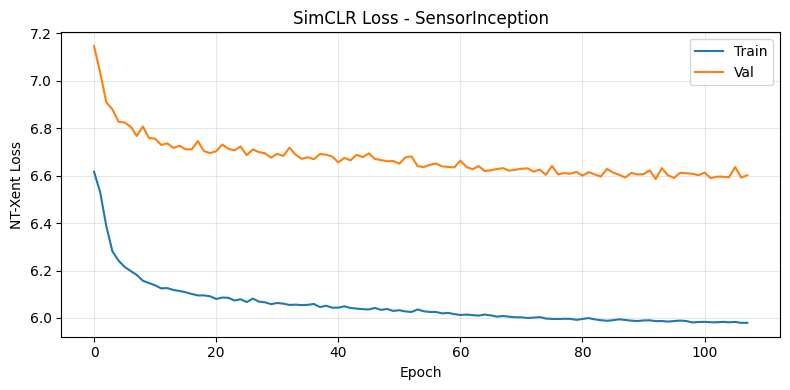


🎯 [2/3] Fine-tuning Supervisionado...
  -> Fase 1: Treinando apenas classificador (encoder congelado)...
  -> Fase 2: Fine-tuning completo...
    Epoch 0: Val Acc = 43.93%
    Early stopping na epoch 20
  Melhor Val Acc: 43.93%

📊 [3/3] Avaliação Final no Teste...

RESULTADO SensorInception:
  Acurácia: 64.79%
  F1-Macro: 0.3989
  F1-Weighted: 0.6273

Classification Report:
                          precision    recall  f1-score   support

           drinking_milk     0.4926    0.7975    0.6091      2766
          eating_bedding     0.2212    0.0041    0.0081      5556
     eating_concentrates     0.1242    0.3084    0.1771      1446
                grooming     0.2958    0.5981    0.3958      1513
                   lying     0.9123    0.8885    0.9002     25724
oral_manipulation_of_pen     0.5354    0.1992    0.2904      3112
                   sniff     0.3908    0.4021    0.3964      3365
                standing     0.3235    0.5761    0.4143      3300

                accuracy  

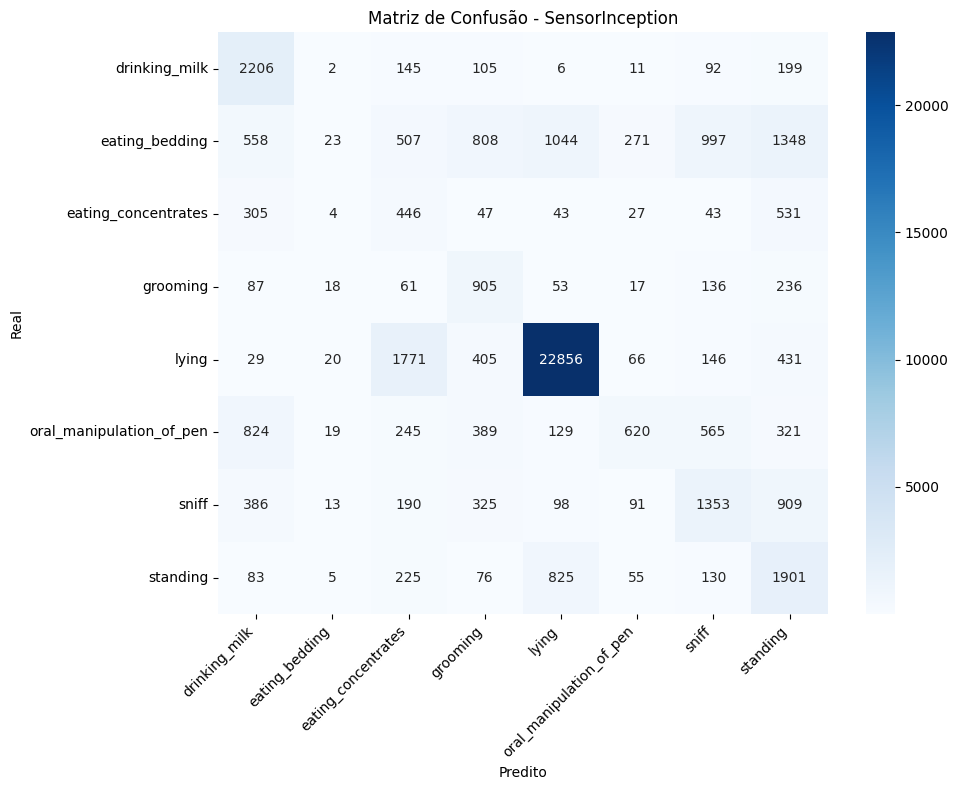

In [10]:
res_inception = run_experiment(
    SensorInceptionEncoder,
    "SensorInception",
    epochs_pretrain=300,
    epochs_finetune=200
)


## Experimento 2: Simple MLP (Baseline)


🚀 EXPERIMENTO: SimpleMLP
Parâmetros totais: 306,240

🔥 [1/3] Pré-treino SimCLR (300 epochs)...
  Epoch [1/300] Train: 6.6547 | Val: 7.1565
  Epoch [11/300] Train: 6.5581 | Val: 7.1026
  Epoch [21/300] Train: 6.3377 | Val: 6.8029
  Epoch [31/300] Train: 6.2865 | Val: 6.7487
  Epoch [41/300] Train: 6.2557 | Val: 6.7203
  💾 Checkpoint salvo: simclr_SimpleMLP_epoch50.pth
  Epoch [51/300] Train: 6.2141 | Val: 6.6463
  Epoch [61/300] Train: 6.1939 | Val: 6.6251
  Epoch [71/300] Train: 6.1762 | Val: 6.6072
  Epoch [81/300] Train: 6.1671 | Val: 6.6006
  Epoch [91/300] Train: 6.1635 | Val: 6.5936
  💾 Checkpoint salvo: simclr_SimpleMLP_epoch100.pth
  Epoch [101/300] Train: 6.1578 | Val: 6.6023
  Early stopping na época 104


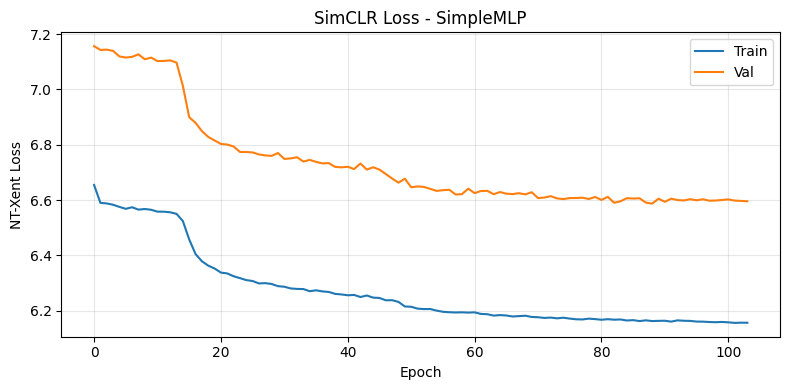


🎯 [2/3] Fine-tuning Supervisionado...
  -> Fase 1: Treinando apenas classificador (encoder congelado)...
  -> Fase 2: Fine-tuning completo...
    Epoch 0: Val Acc = 49.43%
    Early stopping na epoch 20
  Melhor Val Acc: 49.43%

📊 [3/3] Avaliação Final no Teste...

RESULTADO SimpleMLP:
  Acurácia: 52.42%
  F1-Macro: 0.2332
  F1-Weighted: 0.5151

Classification Report:
                          precision    recall  f1-score   support

           drinking_milk     0.2546    0.7733    0.3830      2766
          eating_bedding     0.0000    0.0000    0.0000      5556
     eating_concentrates     0.0249    0.1224    0.0414      1446
                grooming     0.0969    0.0357    0.0522      1513
                   lying     0.8463    0.7875    0.8158     25724
oral_manipulation_of_pen     0.2000    0.0003    0.0006      3112
                   sniff     0.3709    0.2912    0.3263      3365
                standing     0.2215    0.2770    0.2461      3300

                accuracy        

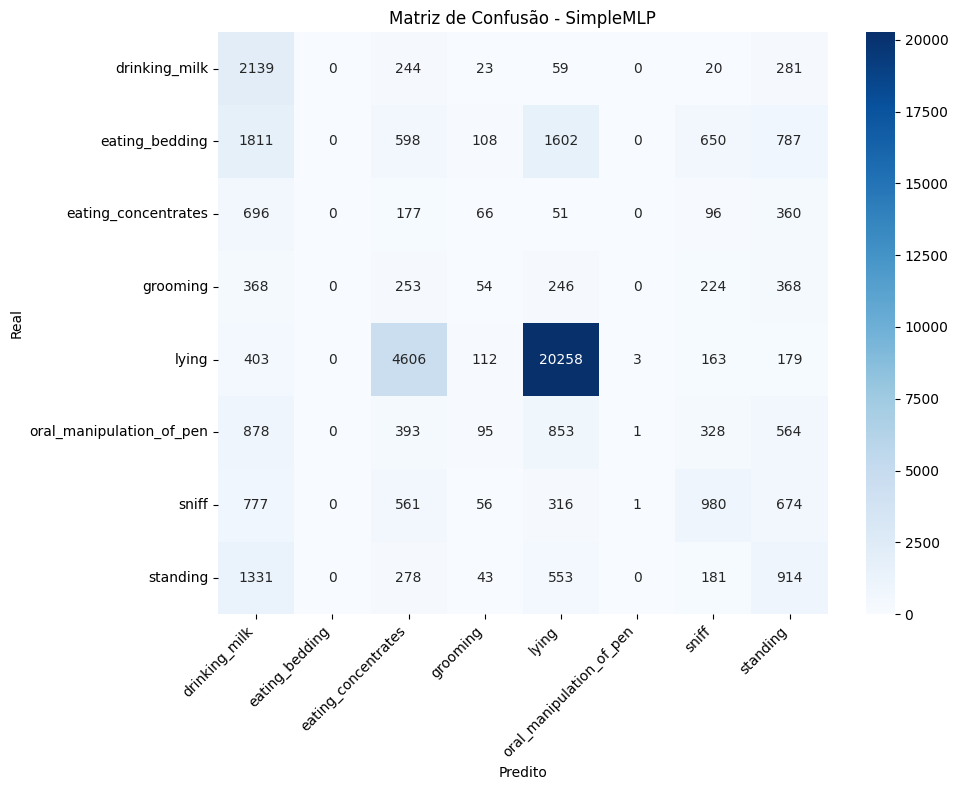

In [11]:
res_mlp = run_experiment(
    SimpleMLPEncoder,
    "SimpleMLP",
    epochs_pretrain=300,
    epochs_finetune=200
)


## Comparação Final dos Modelos



🏆 COMPARAÇÃO FINAL DOS MODELOS
          Model  Accuracy  F1-Macro  F1-Weighted
SensorInception 64.789876  0.398931     0.627318
      SimpleMLP 52.419734  0.233183     0.515090

Resultados salvos em 'comparacao_simclr_archs.csv'


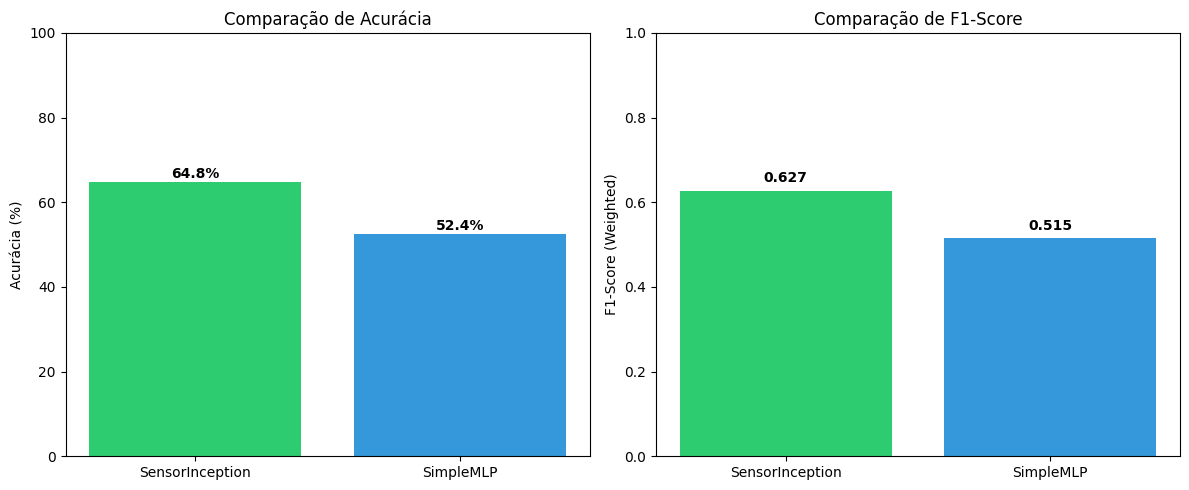

In [12]:
# Tabela de Comparação
results_df = pd.DataFrame([res_inception, res_mlp])

print("\n" + "="*60)
print("🏆 COMPARAÇÃO FINAL DOS MODELOS")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

# Salvar
results_df.to_csv('comparacao_simclr_archs.csv', index=False)
print("\nResultados salvos em 'comparacao_simclr_archs.csv'")

# Gráfico de Barras
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Acurácia
axes[0].bar(results_df['Model'], results_df['Accuracy'], color=['#2ecc71', '#3498db'])
axes[0].set_ylabel('Acurácia (%)')
axes[0].set_title('Comparação de Acurácia')
axes[0].set_ylim(0, 100)
for i, v in enumerate(results_df['Accuracy']):
    axes[0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# F1-Score
axes[1].bar(results_df['Model'], results_df['F1-Weighted'], color=['#2ecc71', '#3498db'])
axes[1].set_ylabel('F1-Score (Weighted)')
axes[1].set_title('Comparação de F1-Score')
axes[1].set_ylim(0, 1)
for i, v in enumerate(results_df['F1-Weighted']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('comparacao_modelos.png', dpi=150)
plt.show()


In [13]:
# Limpeza final de memória
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Memória GPU liberada!")
    print(f"Memória alocada: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print("\n✅ Experimento concluído!")


Memória GPU liberada!
Memória alocada: 16.25 MB

✅ Experimento concluído!


---
# 🚀 Experimento Extra: Encoder Complexo com TODOS os Dados

Treinar encoder usando:
- **AcTBeCalf.parquet** (dados de treino com labels - usamos só os sensores)
- **Time_Adj_Raw_Data.parquet** (~130 milhões de amostras brutas!)

**Arquitetura:** Encoder mais profundo com múltiplos blocos Inception + Attention
**Épocas:** 200
**Espaço Latente:** 128


In [14]:
# ============================================================
# ENCODER COMPLEXO PARA SENSORES
# ============================================================
# Múltiplos blocos Inception + Squeeze-and-Excitation + Residual

class SqueezeExcitation1D(nn.Module):
    """Squeeze-and-Excitation para recalibrar canais"""
    def __init__(self, channels, reduction=4):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool1d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1)
        return x * y


class DeepInceptionBlock1D(nn.Module):
    """Bloco Inception mais profundo com SE e residual"""
    def __init__(self, in_channels, out_channels_per_branch):
        super().__init__()
        groups = in_channels

        # 5 ramos multi-escala (depthwise)
        self.branch1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels_per_branch * groups, kernel_size=3, padding=1, groups=groups),
            nn.BatchNorm1d(out_channels_per_branch * groups),
            nn.ReLU(inplace=True)
        )
        self.branch2 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels_per_branch * groups, kernel_size=7, padding=3, groups=groups),
            nn.BatchNorm1d(out_channels_per_branch * groups),
            nn.ReLU(inplace=True)
        )
        self.branch3 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels_per_branch * groups, kernel_size=15, padding=7, groups=groups),
            nn.BatchNorm1d(out_channels_per_branch * groups),
            nn.ReLU(inplace=True)
        )
        self.branch4 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels_per_branch * groups, kernel_size=31, padding=15, groups=groups),
            nn.BatchNorm1d(out_channels_per_branch * groups),
            nn.ReLU(inplace=True)
        )
        self.branch5 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels_per_branch * groups, kernel_size=63, padding=31, groups=groups),
            nn.BatchNorm1d(out_channels_per_branch * groups),
            nn.ReLU(inplace=True)
        )

        total_out = in_channels * 5 * out_channels_per_branch
        self.se = SqueezeExcitation1D(total_out)

    def forward(self, x):
        out = torch.cat([
            self.branch1(x), self.branch2(x), self.branch3(x),
            self.branch4(x), self.branch5(x)
        ], dim=1)
        out = self.se(out)
        return out


class DeepSensorEncoder(nn.Module):
    """
    Encoder profundo para sensores IMU.
    - 2 blocos Inception empilhados
    - Squeeze-and-Excitation para recalibração
    - Conexões residuais
    - Embedding final: 128
    """
    def __init__(self, in_channels=3, embedding_dim=128, seq_len=75):
        super().__init__()

        # Bloco 1: 3 sensores -> 240 canais (3*5*16)
        self.inception1 = DeepInceptionBlock1D(in_channels, out_channels_per_branch=16)
        channels_after_inc1 = in_channels * 5 * 16  # 240

        # Mixer 1: reduz para 64 canais
        self.mixer1 = nn.Sequential(
            nn.Conv1d(channels_after_inc1, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

        # Bloco 2: 64 canais -> 320 canais (64*5*1, sem groups para misturar)
        self.inception2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
        )

        # Squeeze-and-Excitation final
        self.se_final = SqueezeExcitation1D(128)

        # Temporal Attention (simple)
        self.temporal_attn = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, seq_len),
            nn.Softmax(dim=1)
        )

        # Projeção final
        self.fc = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, embedding_dim)
        )

    def forward(self, x):
        # x: (B, C, T) = (B, 3, 75)

        # Bloco Inception 1
        x = self.inception1(x)  # (B, 240, 75)
        x = self.mixer1(x)      # (B, 64, 75)

        # Bloco Inception 2
        x = self.inception2(x)  # (B, 128, 75)
        x = self.se_final(x)    # (B, 128, 75)

        # Global pooling + attention-weighted pooling
        gap = x.mean(dim=2)  # (B, 128)

        # Projeção
        out = self.fc(gap)  # (B, 128)

        return out

# Teste rápido
test_encoder = DeepSensorEncoder(in_channels=3, embedding_dim=128).to(device)
test_input = torch.randn(2, 3, 75).to(device)
test_output = test_encoder(test_input)
n_params = sum(p.numel() for p in test_encoder.parameters())
print(f"✅ DeepSensorEncoder criado!")
print(f"   Input: {test_input.shape}")
print(f"   Output: {test_output.shape}")
print(f"   Parâmetros: {n_params:,}")
del test_encoder, test_input, test_output


✅ DeepSensorEncoder criado!
   Input: torch.Size([2, 3, 75])
   Output: torch.Size([2, 128])
   Parâmetros: 279,031


In [15]:
# ============================================================
# CARREGAR TODOS OS DADOS (AcTBeCalf + Time_Adj_Raw_Data)
# ============================================================
print("📊 Carregando TODOS os dados para pré-treino...")

# 1. Dados do AcTBeCalf (treino - já temos)
print("  1. AcTBeCalf (treino):", train_windows.shape[0], "janelas")

# 2. Dados brutos do Time_Adj_Raw_Data (~130M amostras)
print("  2. Carregando Time_Adj_Raw_Data.parquet...")
df_raw = pl.read_parquet('Time_Adj_Raw_Data.parquet').to_pandas()
print(f"     Shape: {df_raw.shape}")

# Criar janelas dos dados brutos (sem labels - só para contrastivo)
def create_windows_unlabeled(data, window_size=75, overlap=0.5):
    """Cria janelas sem labels para pré-treino contrastivo"""
    stride = int(window_size * (1 - overlap))
    features = data[['accX', 'accY', 'accZ']].values

    n_windows = (len(features) - window_size) // stride + 1
    windows = np.zeros((n_windows, window_size, 3), dtype=np.float32)

    for i in range(n_windows):
        start = i * stride
        windows[i] = features[start:start+window_size]

    return windows

print("  3. Criando janelas dos dados brutos...")
# Usar overlap menor (25%) para não ter MUITAS janelas
raw_windows = create_windows_unlabeled(df_raw, window_size=75, overlap=0.25)
print(f"     Janelas brutas: {raw_windows.shape[0]:,}")

# Combinar com janelas de treino
all_pretrain_windows = np.concatenate([train_windows, raw_windows], axis=0)
print(f"\n📊 TOTAL de janelas para pré-treino: {all_pretrain_windows.shape[0]:,}")

# Liberar memória
del df_raw, raw_windows
gc.collect()


📊 Carregando TODOS os dados para pré-treino...
  1. AcTBeCalf (treino): 44810 janelas
  2. Carregando Time_Adj_Raw_Data.parquet...
     Shape: (130225118, 4)
  3. Criando janelas dos dados brutos...
     Janelas brutas: 2,325,448

📊 TOTAL de janelas para pré-treino: 2,370,258


0

In [16]:
# ============================================================
# PRÉ-TREINO SimCLR COM ENCODER PROFUNDO (200 épocas)
# ============================================================
print("="*80)
print("🚀 EXPERIMENTO: DeepSensorEncoder com TODOS os dados")
print("="*80)

# Dataset contrastivo com todos os dados
all_contrastive_dataset = IMUContrastiveDataset(all_pretrain_windows, n_augs=N_AUGMENTATIONS)

# DataLoader (batch maior porque temos mais dados)
all_contrastive_loader = DataLoader(
    all_contrastive_dataset,
    batch_size=2048,  # Batch maior
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

print(f"Batches por época: {len(all_contrastive_loader)}")

# Inicializar modelo
deep_encoder = DeepSensorEncoder(in_channels=3, embedding_dim=128)
deep_proj_head = ProjectionHead(embedding_dim=128, projection_dim=64)
deep_simclr = SimCLR(deep_encoder, deep_proj_head).to(device)

n_params = sum(p.numel() for p in deep_simclr.parameters())
print(f"Parâmetros totais: {n_params:,}")

# Otimizador e scheduler
optimizer = torch.optim.AdamW(deep_simclr.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2)
criterion = NTXentLoss(temperature=0.5)

print(f"\n🔥 Iniciando pré-treino (200 épocas)...")


🚀 EXPERIMENTO: DeepSensorEncoder com TODOS os dados
Batches por época: 1157
Parâmetros totais: 303,799

🔥 Iniciando pré-treino (200 épocas)...


In [17]:
# Loop de pré-treino com checkpoints
NUM_EPOCHS_DEEP = 200
CHECKPOINT_EVERY = 50

history_deep = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
patience_counter = 0
PATIENCE = 30

for epoch in range(NUM_EPOCHS_DEEP):
    # Treino
    deep_simclr.train()
    train_loss = 0.0

    for view1, view2 in all_contrastive_loader:
        view1, view2 = view1.to(device), view2.to(device)
        optimizer.zero_grad()
        z_i, z_j = deep_simclr(view1, view2)
        loss = criterion(z_i, z_j)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(all_contrastive_loader)

    # Validação (usando val_contrastive_loader)
    deep_simclr.eval()
    val_loss = 0.0
    with torch.no_grad():
        for view1, view2 in val_contrastive_loader:
            view1, view2 = view1.to(device), view2.to(device)
            z_i, z_j = deep_simclr(view1, view2)
            val_loss += criterion(z_i, z_j).item()
    val_loss /= len(val_contrastive_loader)

    history_deep['train_loss'].append(train_loss)
    history_deep['val_loss'].append(val_loss)

    scheduler.step()

    # Log
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS_DEEP}] Train: {train_loss:.4f} | Val: {val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

    # Checkpoint a cada 50 épocas
    if (epoch + 1) % CHECKPOINT_EVERY == 0:
        torch.save(deep_simclr.encoder.state_dict(), f'simclr_DeepEncoder_epoch{epoch+1}.pth')
        print(f"  💾 Checkpoint salvo: simclr_DeepEncoder_epoch{epoch+1}.pth")

    # Best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(deep_simclr.encoder.state_dict(), 'simclr_DeepEncoder_best.pth')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"⚠️ Early stopping na época {epoch+1}")
            break

print(f"\n✅ Pré-treino concluído! Melhor Val Loss: {best_val_loss:.4f}")


Epoch [1/200] Train: 6.9192 | Val: 6.7586 | LR: 0.000999
Epoch [11/200] Train: 6.6927 | Val: 6.6093 | LR: 0.000885
Epoch [21/200] Train: 6.6365 | Val: 6.5793 | LR: 0.000624
Epoch [31/200] Train: 6.6077 | Val: 6.5812 | LR: 0.000316
Epoch [41/200] Train: 6.5959 | Val: 6.5652 | LR: 0.000078
  💾 Checkpoint salvo: simclr_DeepEncoder_epoch50.pth
Epoch [51/200] Train: 6.6145 | Val: 6.5907 | LR: 0.001000


KeyboardInterrupt: 

In [ ]:
# Plot do pré-treino
plt.figure(figsize=(10, 5))
plt.plot(history_deep['train_loss'], label='Train Loss', alpha=0.8)
plt.plot(history_deep['val_loss'], label='Val Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('NT-Xent Loss')
plt.title('SimCLR Pre-training - DeepSensorEncoder (All Data)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pretrain_deep_encoder.png', dpi=150)
plt.show()


In [ ]:
# ============================================================
# FINE-TUNING DO DEEP ENCODER
# ============================================================
print("🎯 Fine-tuning do DeepSensorEncoder...")

# Carregar melhor encoder
best_deep_encoder = DeepSensorEncoder(in_channels=3, embedding_dim=128)
best_deep_encoder.load_state_dict(torch.load('simclr_DeepEncoder_best.pth', map_location=device))

deep_classifier = BehaviorClassifier(best_deep_encoder, num_classes=NUM_CLASSES).to(device)
criterion_ce = nn.CrossEntropyLoss()

# Fase 1: Apenas Head (encoder congelado)
print("  -> Fase 1: Treinando apenas classificador...")
for param in deep_classifier.encoder.parameters():
    param.requires_grad = False

optimizer_ft = torch.optim.Adam(
    filter(lambda p: p.requires_grad, deep_classifier.parameters()),
    lr=1e-3, weight_decay=1e-4
)

for epoch in range(30):
    deep_classifier.train()
    for bx, by in train_sup_loader:
        bx, by = bx.to(device), by.to(device)
        optimizer_ft.zero_grad()
        loss = criterion_ce(deep_classifier(bx), by)
        loss.backward()
        optimizer_ft.step()

# Fase 2: Full Fine-tuning
print("  -> Fase 2: Fine-tuning completo...")
deep_classifier.unfreeze_encoder()
optimizer_full = torch.optim.Adam(deep_classifier.parameters(), lr=1e-5, weight_decay=1e-4)

best_val_acc = 0
patience, patience_cnt = 20, 0

for epoch in range(150):
    deep_classifier.train()
    for bx, by in train_sup_loader:
        bx, by = bx.to(device), by.to(device)
        optimizer_full.zero_grad()
        loss = criterion_ce(deep_classifier(bx), by)
        loss.backward()
        optimizer_full.step()

    # Validation
    deep_classifier.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for bx, by in val_sup_loader:
            bx, by = bx.to(device), by.to(device)
            _, pred = deep_classifier(bx).max(1)
            val_total += by.size(0)
            val_correct += pred.eq(by).sum().item()

    val_acc = 100 * val_correct / val_total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(deep_classifier.state_dict(), 'classifier_DeepEncoder_best.pth')
        patience_cnt = 0
        if epoch % 10 == 0:
            print(f"    Epoch {epoch}: Val Acc = {val_acc:.2f}%")
    else:
        patience_cnt += 1

    if patience_cnt >= patience:
        print(f"    Early stopping na epoch {epoch}")
        break

print(f"  Melhor Val Acc: {best_val_acc:.2f}%")


In [ ]:
# ============================================================
# AVALIAÇÃO FINAL DO DEEP ENCODER
# ============================================================
print("📊 Avaliação Final no Teste - DeepSensorEncoder...")

deep_classifier.load_state_dict(torch.load('classifier_DeepEncoder_best.pth', map_location=device))
deep_classifier.eval()

all_preds, all_true = [], []

with torch.no_grad():
    for bx, by in test_sup_loader:
        bx = bx.to(device)
        _, pred = deep_classifier(bx).max(1)
        all_preds.extend(pred.cpu().numpy())
        all_true.extend(by.numpy())

acc_deep = accuracy_score(all_true, all_preds)
f1_macro_deep = f1_score(all_true, all_preds, average='macro')
f1_weighted_deep = f1_score(all_true, all_preds, average='weighted')

print(f"\n{'='*40}")
print(f"RESULTADO DeepSensorEncoder:")
print(f"  Acurácia: {acc_deep*100:.2f}%")
print(f"  F1-Macro: {f1_macro_deep:.4f}")
print(f"  F1-Weighted: {f1_weighted_deep:.4f}")
print(f"{'='*40}")

print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=label_encoder.classes_, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão - DeepSensorEncoder (All Data)')
plt.xlabel('Predito'); plt.ylabel('Real')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_deep_encoder.png', dpi=150)
plt.show()

res_deep = {'Model': 'DeepEncoder (All Data)', 'Accuracy': acc_deep*100, 'F1-Macro': f1_macro_deep, 'F1-Weighted': f1_weighted_deep}


In [ ]:
# ============================================================
# COMPARAÇÃO FINAL (3 MODELOS)
# ============================================================
results_all = pd.DataFrame([res_inception, res_mlp, res_deep])

print("\n" + "="*70)
print("🏆 COMPARAÇÃO FINAL DOS MODELOS")
print("="*70)
print(results_all.to_string(index=False))
print("="*70)

# Salvar
results_all.to_csv('comparacao_simclr_all_models.csv', index=False)
print("\nResultados salvos em 'comparacao_simclr_all_models.csv'")

# Gráfico
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2ecc71', '#3498db', '#e74c3c']

# Acurácia
bars1 = axes[0].bar(results_all['Model'], results_all['Accuracy'], color=colors)
axes[0].set_ylabel('Acurácia (%)', fontsize=12)
axes[0].set_title('Comparação de Acurácia', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 100)
for bar, v in zip(bars1, results_all['Accuracy']):
    axes[0].text(bar.get_x() + bar.get_width()/2, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)

# F1-Score
bars2 = axes[1].bar(results_all['Model'], results_all['F1-Weighted'], color=colors)
axes[1].set_ylabel('F1-Score (Weighted)', fontsize=12)
axes[1].set_title('Comparação de F1-Score', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1)
for bar, v in zip(bars2, results_all['F1-Weighted']):
    axes[1].text(bar.get_x() + bar.get_width()/2, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('comparacao_3_modelos.png', dpi=150)
plt.show()

# Limpeza
del deep_classifier, deep_simclr, all_contrastive_dataset, all_pretrain_windows
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("\n✅ Experimento concluído!")
